In [1]:
import influxdb_client
import pandas as pd

In [2]:
TOKEN = '80pzM9UJharBRVfSbBIfecydGJsX80ihx2IZsd7UmAZUhUumZTIiX9jUqQNytXPxeVuZlgLmHAY6JOyHnLZuJw=='
URL = 'http://localhost:8086'
ORG = 'VCT'
BUCKET = 'HOUSE_HOLD_ENERGY'

In [3]:
client = influxdb_client.InfluxDBClient(url=URL, token=TOKEN, org=ORG,  timeout=30000)

In [4]:
query_api = client.query_api()

In [5]:
query = f'''
from(bucket: "{BUCKET}")
  |> range(start: 2007-01-01T00:00:00Z, stop: 2007-12-31T00:00:00Z)
  |> filter(fn: (r) => r["_measurement"] == "house_energy")
  |> filter(fn: (r) => r["_field"] == "Global_active_power" or 
                      r["_field"] == "Global_reactive_power" or 
                      r["_field"] == "Voltage" or 
                      r["_field"] == "Global_intensity" or 
                      r["_field"] == "Sub_metering_1" or 
                      r["_field"] == "Sub_metering_2" or 
                      r["_field"] == "Sub_metering_3")
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
'''

In [6]:
house_hold_energy_2007 = query_api.query_data_frame(query=query)

In [7]:
house_hold_energy_2007.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524160 entries, 0 to 524159
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   result                 524160 non-null  object             
 1   table                  524160 non-null  int64              
 2   _start                 524160 non-null  datetime64[ns, UTC]
 3   _stop                  524160 non-null  datetime64[ns, UTC]
 4   _time                  524160 non-null  datetime64[ns, UTC]
 5   _measurement           524160 non-null  object             
 6   Global_active_power    524160 non-null  object             
 7   Global_intensity       524160 non-null  object             
 8   Global_reactive_power  524160 non-null  object             
 9   Sub_metering_1         524160 non-null  object             
 10  Sub_metering_2         524160 non-null  object             
 11  Sub_metering_3         520229 non-null 

#### Limpando dataframe

##### Retirando dados desnecessários

In [8]:
house_hold_energy_2007.drop(columns=['result', 'table', '_start', '_stop', '_measurement'], inplace=True)
house_hold_energy_2007.head(10)

,_time,Global_active_power,Global_intensity,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,Voltage
0,2007-01-01 00:00:00+00:00,2.580,10.600,0.136,0.000,0.000,0.0,241.970
1,2007-01-01 00:01:00+00:00,2.552,10.400,0.100,0.000,0.000,0.0,241.750
2,2007-01-01 00:02:00+00:00,2.550,10.400,0.100,0.000,0.000,0.0,241.640
3,2007-01-01 00:03:00+00:00,2.550,10.400,0.100,0.000,0.000,0.0,241.710
4,2007-01-01 00:04:00+00:00,2.554,10.400,0.100,0.000,0.000,0.0,241.980
5,2007-01-01 00:05:00+00:00,2.550,10.400,0.100,0.000,0.000,0.0,241.830
6,2007-01-01 00:06:00+00:00,2.534,10.400,0.096,0.000,0.000,0.0,241.070
7,2007-01-01 00:07:00+00:00,2.484,10.200,0.000,0.000,0.000,0.0,241.290
8,2007-01-01 00:08:00+00:00,2.468,10.200,0.000,0.000,0.000,0.0,241.230
9,2007-01-01 00:09:00+00:00,2.486,10.200,0.000,0.000,0.000,0.0,242.180


In [10]:
columns_float = list(house_hold_energy_2007.iloc[:, 1:].columns)
columns_float

['Global_active_power',
 'Global_intensity',
 'Global_reactive_power',
 'Sub_metering_1',
 'Sub_metering_2',
 'Sub_metering_3',
 'Voltage']

#### Encontrando dados nulos dados nulos

In [12]:
rows_null = house_hold_energy_2007.query('Global_active_power == "?"').index
rows_null

Index([ 19836,  39913,  76258,  76259, 120592, 168501, 168502, 168503, 168504,
       168505,
       ...
       305791, 305792, 339503, 387175, 387176, 426113, 426114, 467824, 478257,
       505331],
      dtype='int64', length=3931)

In [14]:
house_hold_energy_2007.iloc[rows_null].head(10)

,_time,Global_active_power,Global_intensity,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,Voltage
19836,2007-01-14 18:36:00+00:00,?,?,?,?,?,NaN,?
39913,2007-01-28 17:13:00+00:00,?,?,?,?,?,NaN,?
76258,2007-02-22 22:58:00+00:00,?,?,?,?,?,NaN,?
76259,2007-02-22 22:59:00+00:00,?,?,?,?,?,NaN,?
120592,2007-03-25 17:52:00+00:00,?,?,?,?,?,NaN,?
168501,2007-04-28 00:21:00+00:00,?,?,?,?,?,NaN,?
168502,2007-04-28 00:22:00+00:00,?,?,?,?,?,NaN,?
168503,2007-04-28 00:23:00+00:00,?,?,?,?,?,NaN,?
168504,2007-04-28 00:24:00+00:00,?,?,?,?,?,NaN,?
168505,2007-04-28 00:25:00+00:00,?,?,?,?,?,NaN,?


In [16]:
house_hold_energy_2007.replace("?", 0.0, inplace=True)
house_hold_energy_2007.iloc[rows_null].head(10)

,_time,Global_active_power,Global_intensity,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,Voltage
19836,2007-01-14 18:36:00+00:00,0.0,0.0,0.0,0.0,0.0,NaN,0.0
39913,2007-01-28 17:13:00+00:00,0.0,0.0,0.0,0.0,0.0,NaN,0.0
76258,2007-02-22 22:58:00+00:00,0.0,0.0,0.0,0.0,0.0,NaN,0.0
76259,2007-02-22 22:59:00+00:00,0.0,0.0,0.0,0.0,0.0,NaN,0.0
120592,2007-03-25 17:52:00+00:00,0.0,0.0,0.0,0.0,0.0,NaN,0.0
168501,2007-04-28 00:21:00+00:00,0.0,0.0,0.0,0.0,0.0,NaN,0.0
168502,2007-04-28 00:22:00+00:00,0.0,0.0,0.0,0.0,0.0,NaN,0.0
168503,2007-04-28 00:23:00+00:00,0.0,0.0,0.0,0.0,0.0,NaN,0.0
168504,2007-04-28 00:24:00+00:00,0.0,0.0,0.0,0.0,0.0,NaN,0.0
168505,2007-04-28 00:25:00+00:00,0.0,0.0,0.0,0.0,0.0,NaN,0.0


In [18]:
house_hold_energy_2007.fillna(0.0, inplace=True)
house_hold_energy_2007.iloc[rows_null].head(10)

,_time,Global_active_power,Global_intensity,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,Voltage
19836,2007-01-14 18:36:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39913,2007-01-28 17:13:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76258,2007-02-22 22:58:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76259,2007-02-22 22:59:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120592,2007-03-25 17:52:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168501,2007-04-28 00:21:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168502,2007-04-28 00:22:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168503,2007-04-28 00:23:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168504,2007-04-28 00:24:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168505,2007-04-28 00:25:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
house_hold_energy_2007.interpolate(inplace=True)
house_hold_energy_2007.iloc[rows_null]

C:\Users\victo\AppData\Local\Temp\ipykernel_62400\3209917408.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  house_hold_energy_2007.interpolate(inplace=True)


,_time,Global_active_power,Global_intensity,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,Voltage
19836,2007-01-14 18:36:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39913,2007-01-28 17:13:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76258,2007-02-22 22:58:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76259,2007-02-22 22:59:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120592,2007-03-25 17:52:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
426113,2007-10-23 21:53:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
426114,2007-10-23 21:54:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
467824,2007-11-21 21:04:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
478257,2007-11-29 02:57:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Convertendo colunas numericas

In [21]:
house_hold_energy_2007[columns_float] = house_hold_energy_2007[columns_float].astype(float)

In [22]:
house_hold_energy_2007.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524160 entries, 0 to 524159
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   _time                  524160 non-null  datetime64[ns, UTC]
 1   Global_active_power    524160 non-null  float64            
 2   Global_intensity       524160 non-null  float64            
 3   Global_reactive_power  524160 non-null  float64            
 4   Sub_metering_1         524160 non-null  float64            
 5   Sub_metering_2         524160 non-null  float64            
 6   Sub_metering_3         524160 non-null  float64            
 7   Voltage                524160 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(7)
memory usage: 32.0 MB


#### Adicionando coluna de consumo total (Global_active_power * 1000 / 60 - Sub_metering_1 - Sub_metering_2 - Sub_metering_3)

In [23]:
house_hold_energy_2007["Energy_consumed"] = house_hold_energy_2007["Global_active_power"] * 1000 / 60 - house_hold_energy_2007["Sub_metering_1"] - house_hold_energy_2007["Sub_metering_2"] - house_hold_energy_2007["Sub_metering_3"]
house_hold_energy_2007.head(10)

,_time,Global_active_power,Global_intensity,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,Voltage,Energy_consumed
0,2007-01-01 00:00:00+00:00,2.580,10.6,0.136,0.0,0.0,0.0,241.97,43.000000
1,2007-01-01 00:01:00+00:00,2.552,10.4,0.100,0.0,0.0,0.0,241.75,42.533333
2,2007-01-01 00:02:00+00:00,2.550,10.4,0.100,0.0,0.0,0.0,241.64,42.500000
3,2007-01-01 00:03:00+00:00,2.550,10.4,0.100,0.0,0.0,0.0,241.71,42.500000
4,2007-01-01 00:04:00+00:00,2.554,10.4,0.100,0.0,0.0,0.0,241.98,42.566667
5,2007-01-01 00:05:00+00:00,2.550,10.4,0.100,0.0,0.0,0.0,241.83,42.500000
6,2007-01-01 00:06:00+00:00,2.534,10.4,0.096,0.0,0.0,0.0,241.07,42.233333
7,2007-01-01 00:07:00+00:00,2.484,10.2,0.000,0.0,0.0,0.0,241.29,41.400000
8,2007-01-01 00:08:00+00:00,2.468,10.2,0.000,0.0,0.0,0.0,241.23,41.133333
9,2007-01-01 00:09:00+00:00,2.486,10.2,0.000,0.0,0.0,0.0,242.18,41.433333


#### Renomeando Sub_meterings

In [24]:
rename_columns = {
    "Sub_metering_1" : "Kitchen",
    "Sub_metering_2" : "Laundry_Room",
    "Sub_metering_3" : "Heater_conditioner"
}

In [28]:
house_hold_energy_2007.rename(columns=rename_columns, inplace=True)

In [29]:
house_hold_energy_2007.head(10)

,_time,Global_active_power,Global_intensity,Global_reactive_power,Kitchen,Laundry_Room,Heater_conditioner,Voltage,Energy_consumed
0,2007-01-01 00:00:00+00:00,2.580,10.6,0.136,0.0,0.0,0.0,241.97,43.000000
1,2007-01-01 00:01:00+00:00,2.552,10.4,0.100,0.0,0.0,0.0,241.75,42.533333
2,2007-01-01 00:02:00+00:00,2.550,10.4,0.100,0.0,0.0,0.0,241.64,42.500000
3,2007-01-01 00:03:00+00:00,2.550,10.4,0.100,0.0,0.0,0.0,241.71,42.500000
4,2007-01-01 00:04:00+00:00,2.554,10.4,0.100,0.0,0.0,0.0,241.98,42.566667
5,2007-01-01 00:05:00+00:00,2.550,10.4,0.100,0.0,0.0,0.0,241.83,42.500000
6,2007-01-01 00:06:00+00:00,2.534,10.4,0.096,0.0,0.0,0.0,241.07,42.233333
7,2007-01-01 00:07:00+00:00,2.484,10.2,0.000,0.0,0.0,0.0,241.29,41.400000
8,2007-01-01 00:08:00+00:00,2.468,10.2,0.000,0.0,0.0,0.0,241.23,41.133333
9,2007-01-01 00:09:00+00:00,2.486,10.2,0.000,0.0,0.0,0.0,242.18,41.433333


#### Analisando dias da semana de Janeiro


In [31]:
import matplotlib.pyplot as plt

In [30]:
jan_energy = house_hold_energy_2007[house_hold_energy_2007["_time"].dt.month == 1]
jan_energy

,_time,Global_active_power,Global_intensity,Global_reactive_power,Kitchen,Laundry_Room,Heater_conditioner,Voltage,Energy_consumed
0,2007-01-01 00:00:00+00:00,2.580,10.6,0.136,0.0,0.0,0.0,241.97,43.000000
1,2007-01-01 00:01:00+00:00,2.552,10.4,0.100,0.0,0.0,0.0,241.75,42.533333
2,2007-01-01 00:02:00+00:00,2.550,10.4,0.100,0.0,0.0,0.0,241.64,42.500000
3,2007-01-01 00:03:00+00:00,2.550,10.4,0.100,0.0,0.0,0.0,241.71,42.500000
4,2007-01-01 00:04:00+00:00,2.554,10.4,0.100,0.0,0.0,0.0,241.98,42.566667
...,...,...,...,...,...,...,...,...,...
44635,2007-01-31 23:55:00+00:00,0.334,1.4,0.130,0.0,0.0,0.0,243.80,5.566667
44636,2007-01-31 23:56:00+00:00,0.332,1.4,0.126,0.0,0.0,0.0,243.26,5.533333
44637,2007-01-31 23:57:00+00:00,0.328,1.4,0.124,0.0,0.0,0.0,242.59,5.466667
44638,2007-01-31 23:58:00+00:00,0.328,1.4,0.126,0.0,0.0,0.0,242.87,5.466667


In [58]:
def plot_lines_energy_consume(month_df, day_of_week, day):
    day_week_df = month_df[month_df["_time"].dt.dayofweek == day_of_week][["_time", "Energy_consumed"]]
    day_start = pd.to_datetime(day).date()
    for i in range(4):
        day_stop = (day_start + pd.DateOffset(days=6)).date()
        week_df = day_week_df[(day_week_df["_time"].dt.date >= day_start) & (day_week_df["_time"].dt.date <= day_stop)]
        week_df.plot(kind="line", x="_time", y="Energy_consumed", figsize=(20,5))
        day_start = day_stop
    plt.show()

In [59]:
def plot_box_energy_consume(month_df, day_of_week, day):
    day_week_df = month_df[month_df["_time"].dt.dayofweek == day_of_week][["_time", "Energy_consumed"]]
    day_start = pd.to_datetime(day).date()
    list_dfs = []
    for i in range(4):
        day_stop = (day_start + pd.DateOffset(days=6)).date()
        week_df = day_week_df[(day_week_df["_time"].dt.date >= day_start) & (day_week_df["_time"].dt.date <= day_stop)]
        week_df.plot(kind="box", x="_time", y="Energy_consumed", figsize=(20,5))
        day_start = day_stop
    plt.show()

- Domingos

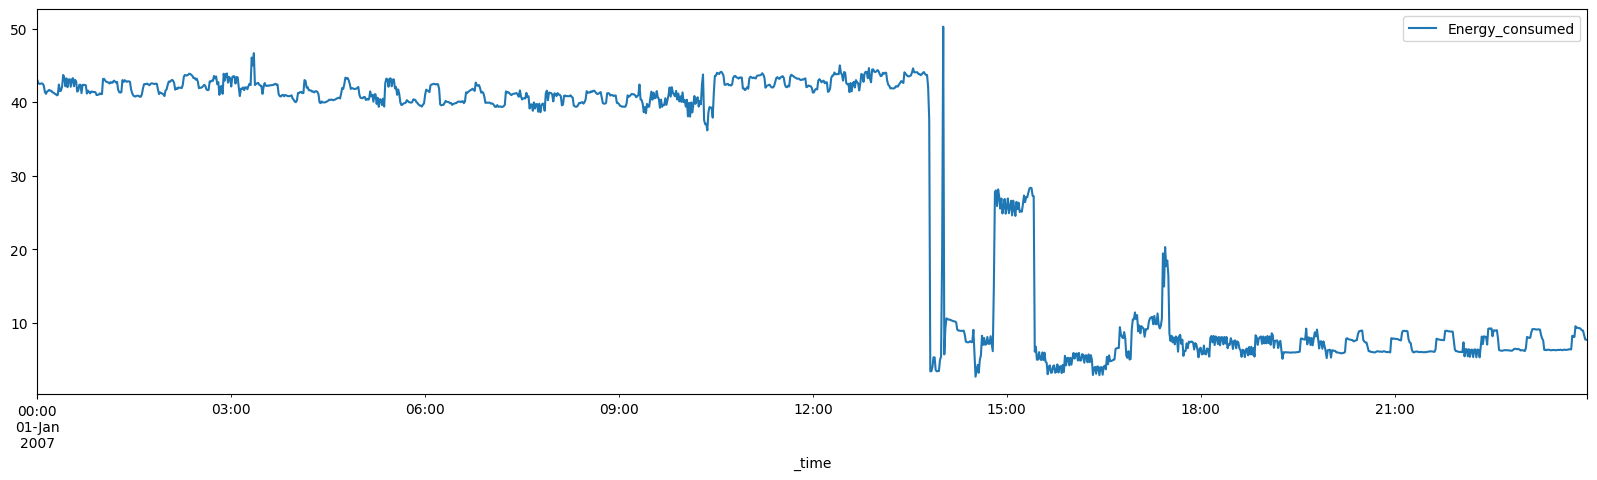

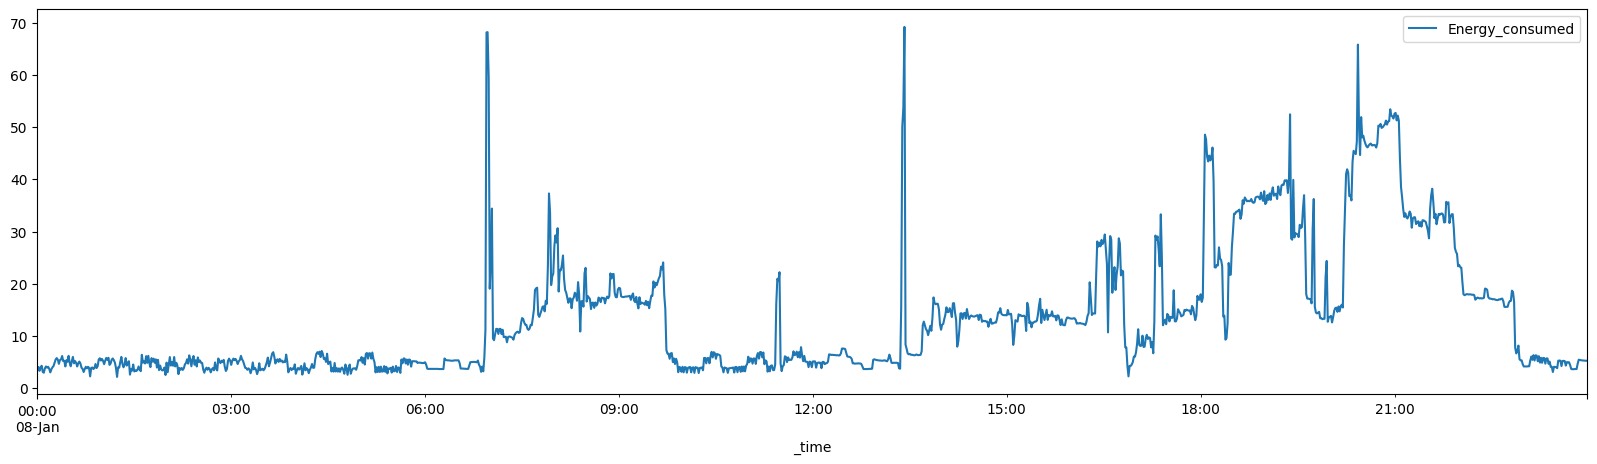

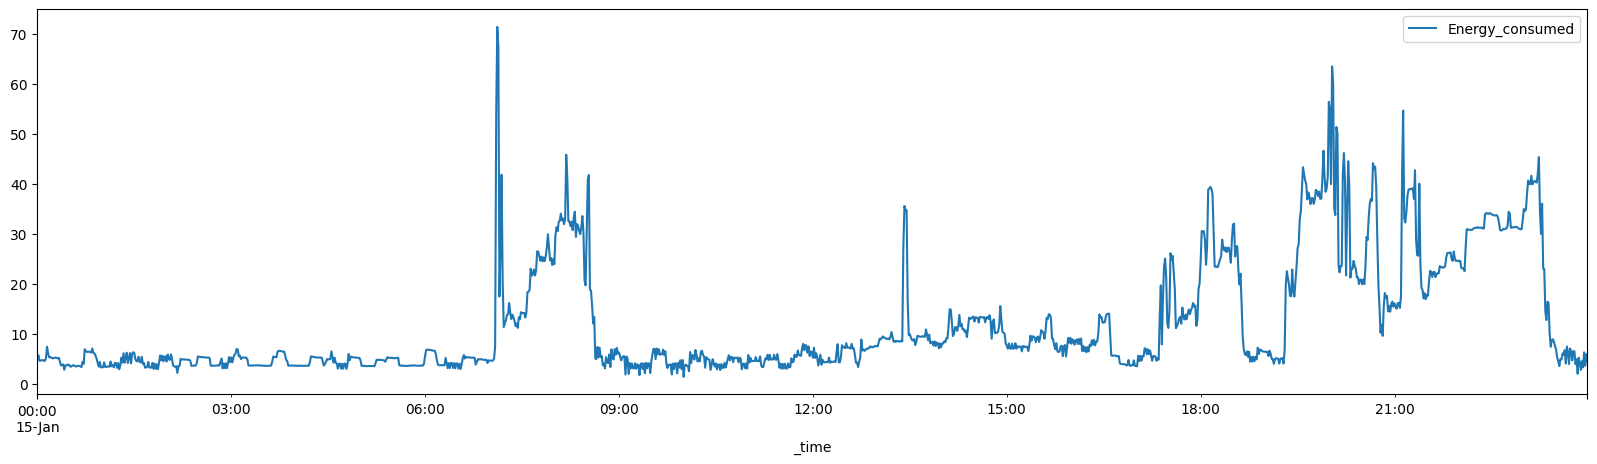

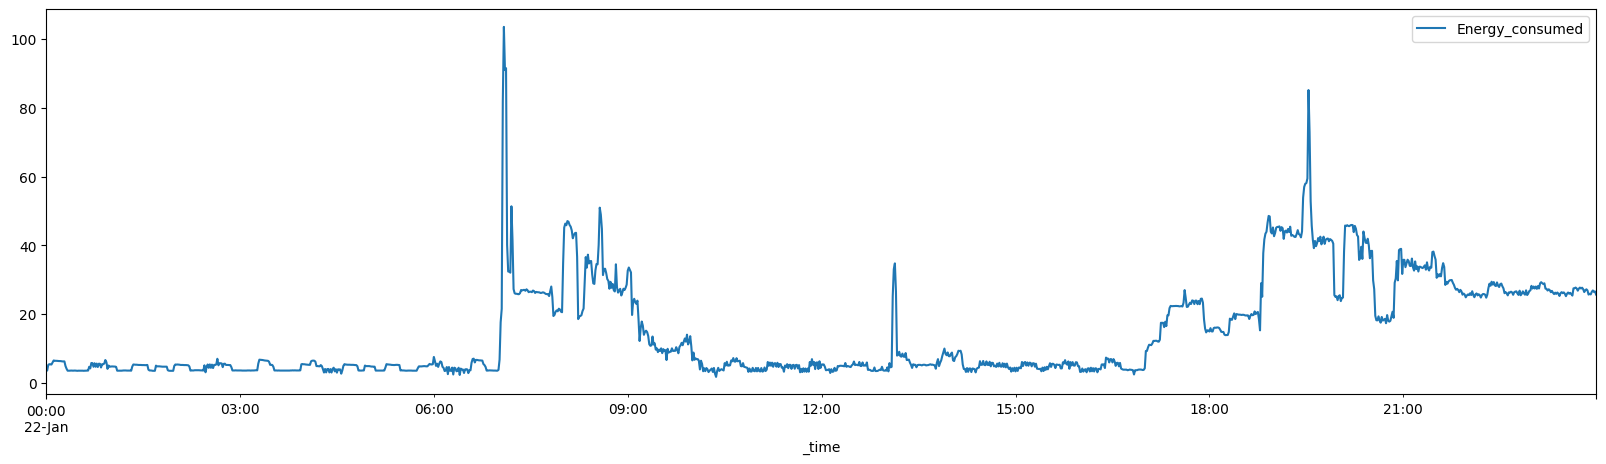

In [60]:
plot_lines_energy_consume(jan_energy, 0, '2007-01-01')

##### Verificando outliers, mediana, simetria e dispersao com boxplot

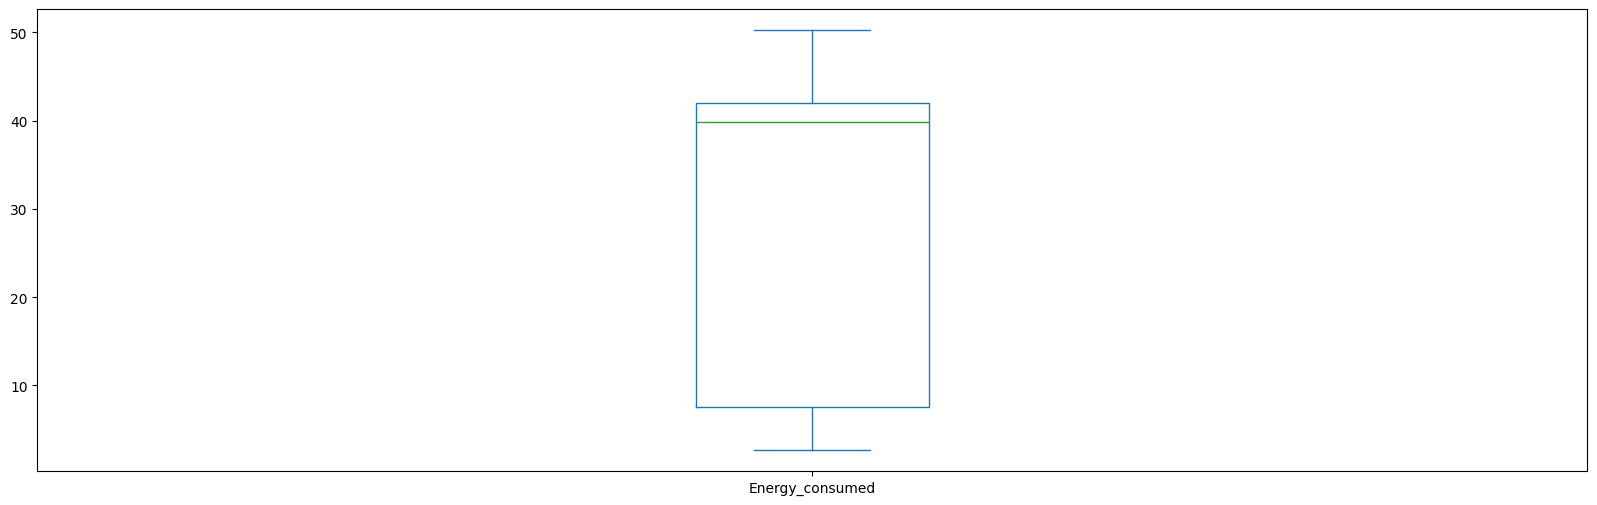

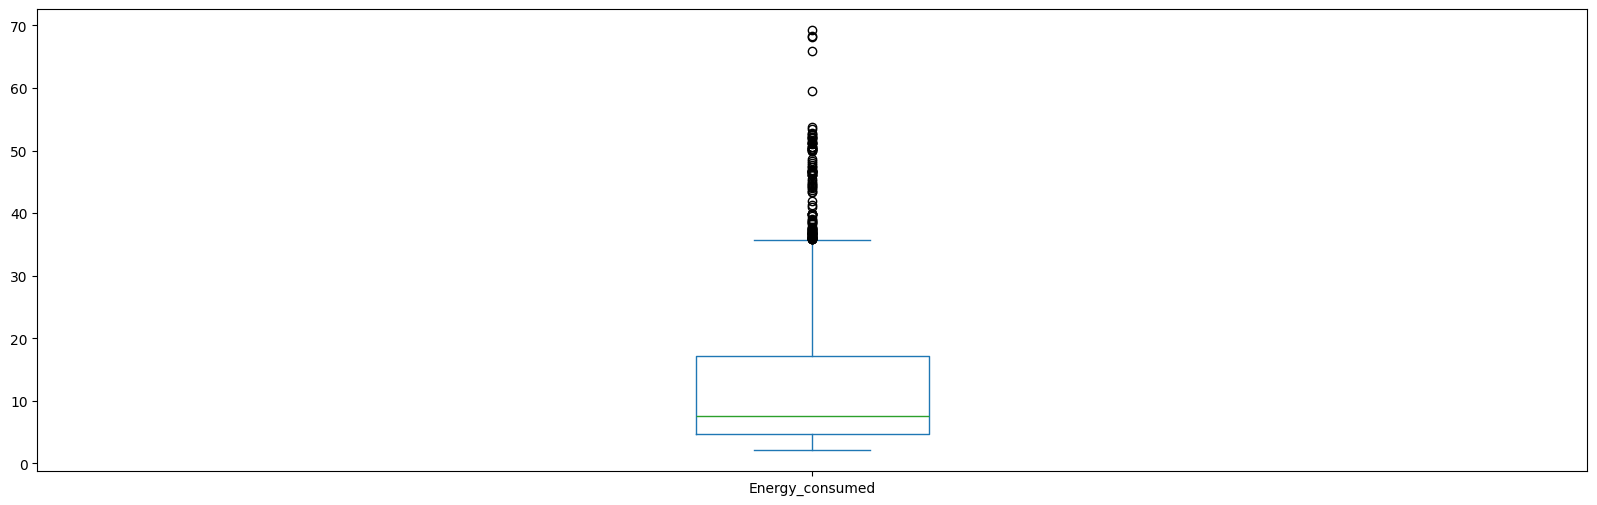

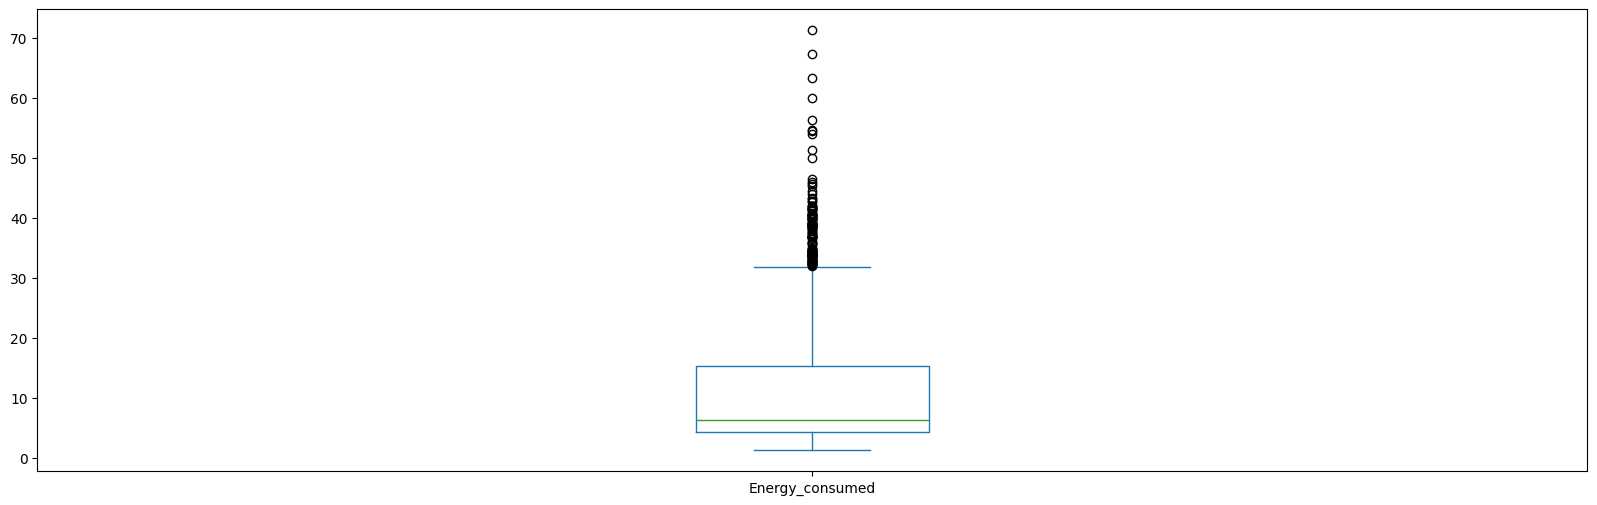

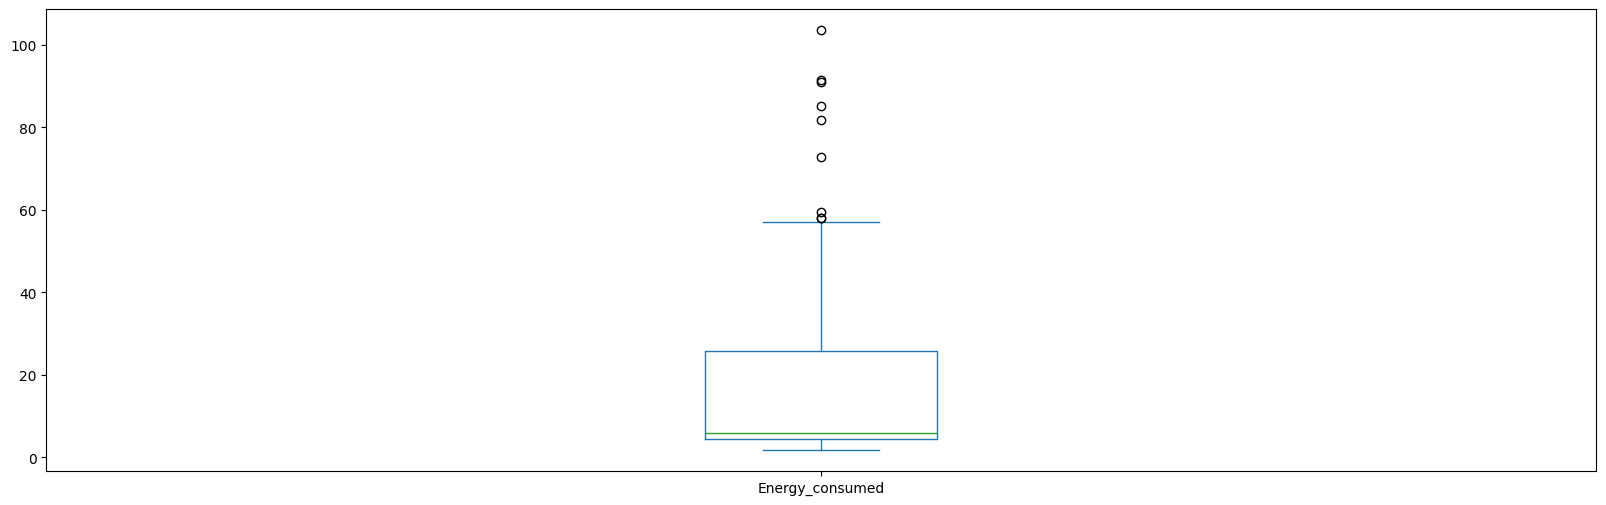

In [57]:
plot_box_energy_consume(jan_energy, 0, '2007-01-01')

- Segundas

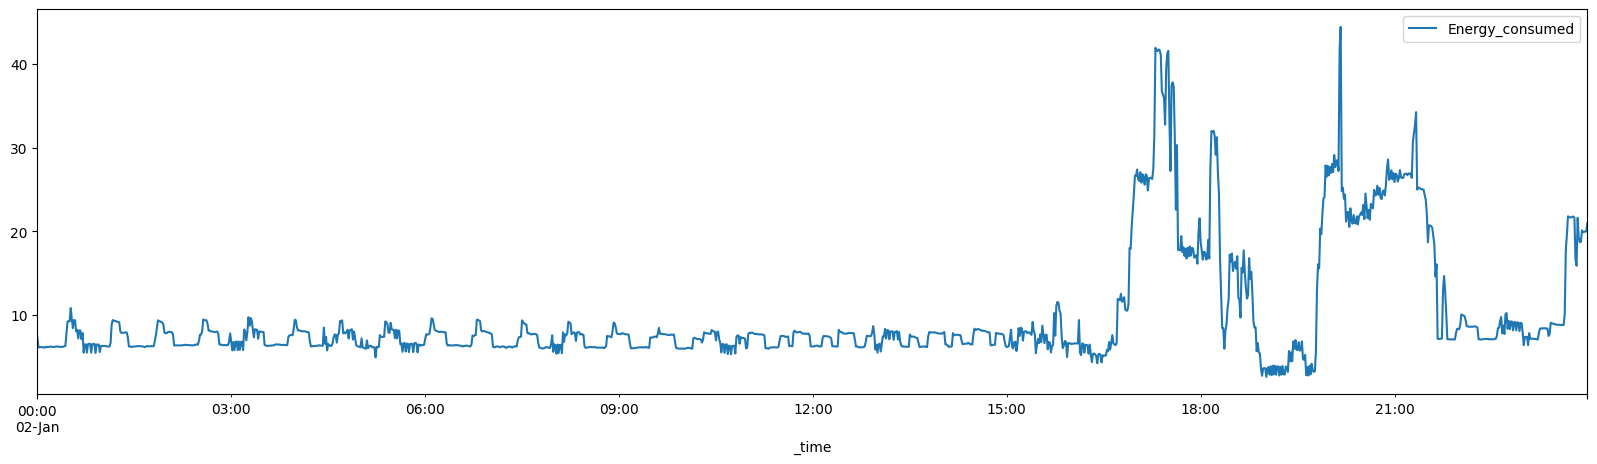

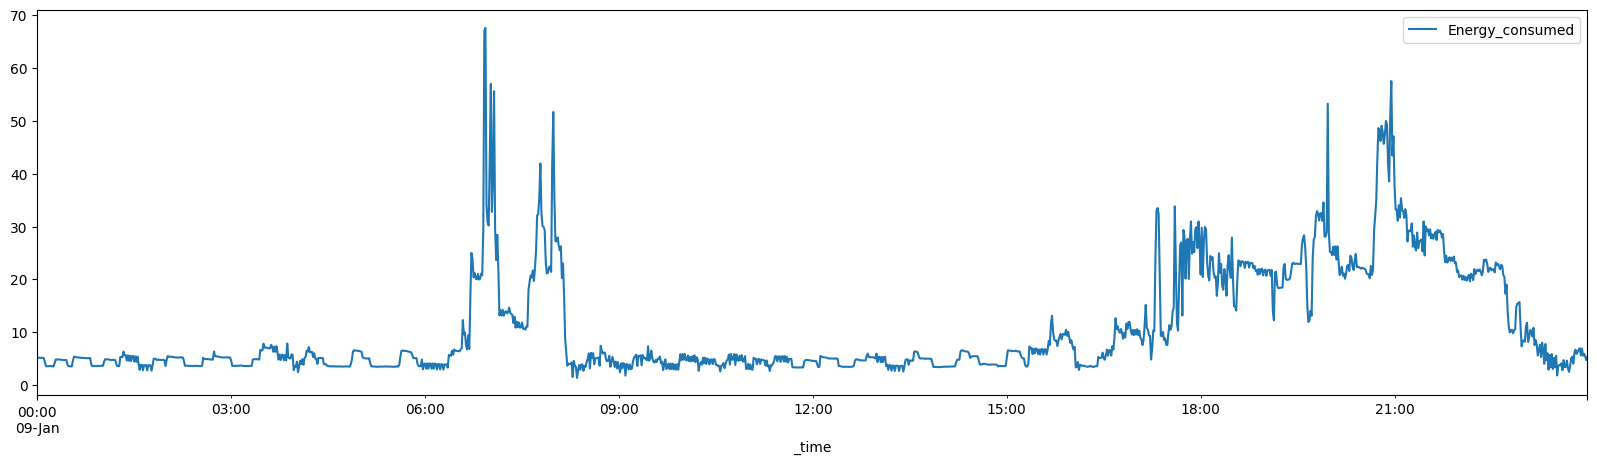

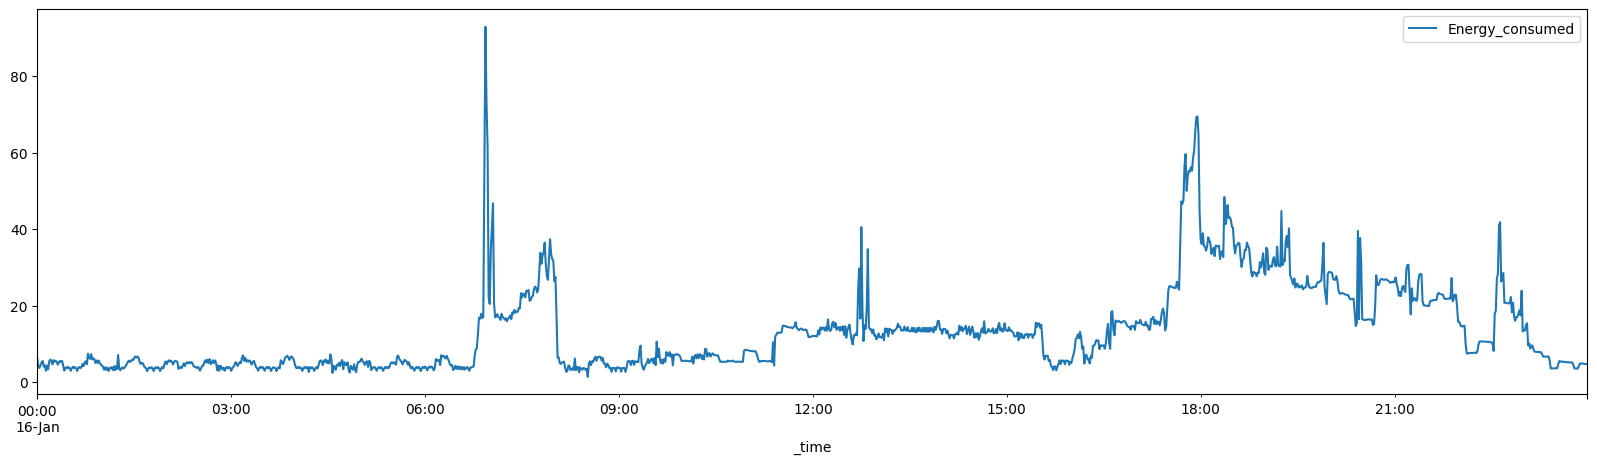

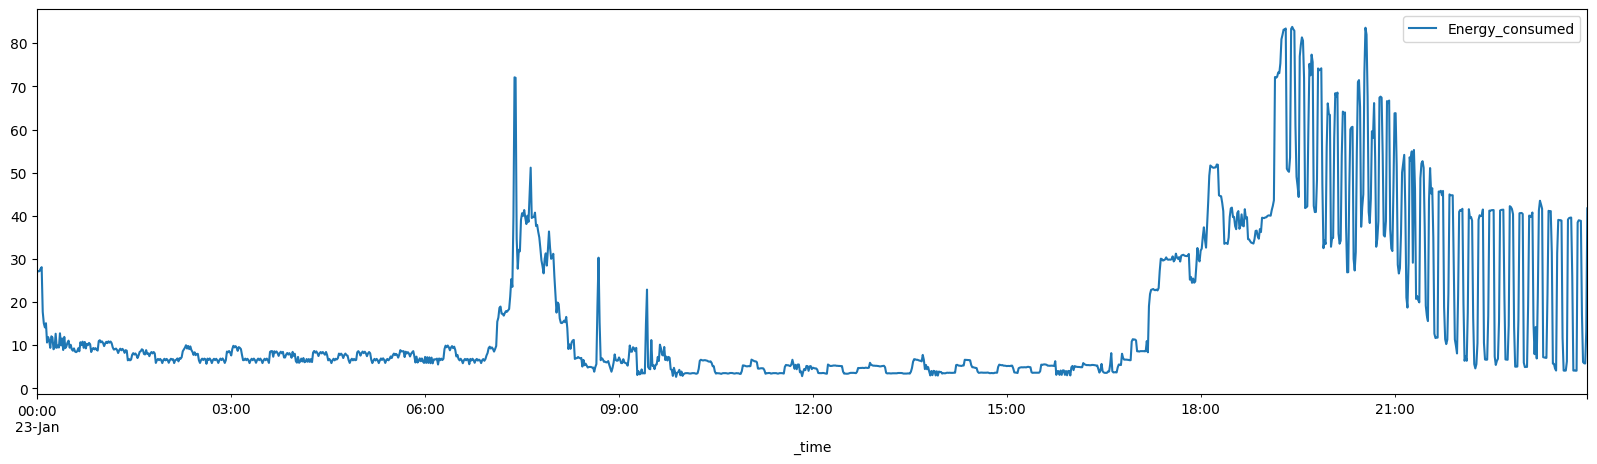

In [63]:
plot_lines_energy_consume(jan_energy, 1, '2007-01-01')

##### Verificando outliers, mediana, simetria e dispersao com boxplot